# FER2013 — MobileNetV2 Training (RGB, 224×224)

- Loads preprocessed FER2013 (`train/val/test`) from your processed folder
- Builds **MobileNetV2 (ImageNet)** + classifier head
- **Warm-up** (frozen backbone) → **fine-tune** top layers with class weights
- Saves **model summaries**, **architecture diagram**, and **training curves**
- Evaluates on **validation** during training; saves **best checkpoints**
- Exports **TFLite INT8** model and measures CPU latency

**Inputs required**
- `index.csv` and `meta.json` under your processed folder
- Processed images in `train/`, `val/`, `test` (RGB, size = `IMG_SIZE` in `meta.json`)

**Outputs**
- `./models/*.keras` (best checkpoints)
- `./reports/*` (summaries, curves, metrics)
- `./exports/mobilenetv2_int8.tflite`


# Import Dependencies

In [3]:
import os, json, time, itertools, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED); np.random.seed(SEED); random.seed(SEED)
tf.get_logger().setLevel("ERROR")




# Paths, meta and datasets

In [5]:
OUT_DIR = Path("../../data/processed/FC211042_Heshani")

meta_path = OUT_DIR / "meta.json"
index_path = OUT_DIR / "index.csv"
assert meta_path.exists(), f"meta.json not found at {meta_path}"
assert index_path.exists(), f"index.csv not found at {index_path}"

meta = json.load(open(meta_path, "r"))
idx  = pd.read_csv(index_path)

CLASSES     = meta["selected_classes"]                       # e.g., ['angry','happy','sad','surprise','neutral']
LABEL2ID    = {k:int(v) for k,v in meta["LABEL2ID"].items()}
ID2LABEL    = {v:k for k,v in LABEL2ID.items()}
CLASS_WTS   = {int(k): float(v) for k,v in meta.get("class_weights", {}).items()}
IMG_SIZE    = int(meta.get("IMG_SIZE", 224))
NUM_CLASSES = len(CLASSES)

print("Classes:", CLASSES)
print("IMG_SIZE:", IMG_SIZE)
print("Images:", len(idx))
print("Class weights:", CLASS_WTS)


Classes: ['angry', 'happy', 'sad', 'surprise', 'neutral']
IMG_SIZE: 224
Images: 30219
Class weights: {0: 1.2101223581757508, 1: 0.6701986754966888, 2: 1.001058201058201, 3: 1.5247372109320252, 4: 0.9739480752014325}


In [8]:
AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 16  # CPU-friendly; adjust if you can

def decode_and_preprocess(filename, label_id):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)         # [0,1]
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img*255.0)  # [-1,1]
    img = tf.reshape(img, [IMG_SIZE, IMG_SIZE, 3])
    return img, label_id

def augment(img, label_id):
    img = tf.image.random_flip_left_right(img)
    return img, label_id

def df_to_ds(df_split, shuffle=True, augment_on=False):
    files  = df_split["path"].tolist()
    labels = [LABEL2ID[l] for l in df_split["label"].tolist()]
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment_on:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_df = idx[idx["split"]=="train"].reset_index(drop=True)
val_df   = idx[idx["split"]=="val"].reset_index(drop=True)
test_df  = idx[idx["split"]=="test"].reset_index(drop=True)  # not used for early stopping, only to sanity-check shapes

train_ds = df_to_ds(train_df, shuffle=True,  augment_on=True)
val_ds   = df_to_ds(val_df,   shuffle=False, augment_on=False)
test_ds  = df_to_ds(test_df,  shuffle=False, augment_on=False)

print(f"Split sizes → train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")


Split sizes → train: 21758, val: 2418, test: 6043


# Build MobileNetV2 model

In [9]:
def build_model(img_size=IMG_SIZE, num_classes=NUM_CLASSES, dropout=0.3, l2w=1e-5, alpha=1.0):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights="imagenet",
        alpha=alpha
    )
    base.trainable = False  # warm-up first

    x = layers.Input(shape=(img_size, img_size, 3))
    y = base(x, training=False)
    y = layers.GlobalAveragePooling2D()(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(num_classes,
                     kernel_regularizer=regularizers.l2(l2w),
                     activation="softmax")(y)
    model = keras.Model(x, y, name=f"MobileNetV2_{img_size}")
    return model, base

model, base = build_model()


# Model summary & diagram

In [10]:
from tensorflow.keras.utils import plot_model

reports_dir = Path("./reports"); reports_dir.mkdir(parents=True, exist_ok=True)

model.summary()
with open(reports_dir / "model_summary.txt", "w", encoding="utf-8") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

try:
    plot_model(model,
               to_file=str(reports_dir/"model_architecture.png"),
               show_shapes=True, show_layer_names=True,
               expand_nested=True, dpi=160)
    print("Saved diagram → reports/model_architecture.png")
except Exception as e:
    print("Diagram not generated (install Graphviz if needed). Error:", e)


Model: "MobileNetV2_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Saved diagram → reports/model_architecture.png


# Warm-up (frozen backbone)

In [28]:
ckpt_dir = Path("./models"); ckpt_dir.mkdir(parents=True, exist_ok=True)
best_warm = str(ckpt_dir / "mobilenetv2_warmup_best.keras")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks_warm = [
    keras.callbacks.ModelCheckpoint(best_warm, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1)
]

WARMUP_EPOCHS = 5
hist_warm = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=WARMUP_EPOCHS,
    class_weight=CLASS_WTS if CLASS_WTS else None,
    callbacks=callbacks_warm,
    verbose=1
)


Epoch 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.3758 - loss: 1.5303
Epoch 1: val_accuracy improved from None to 0.54301, saving model to models\mobilenetv2_warmup_best.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 261s 189ms/step - accuracy: 0.4366 - loss: 1.3896 - val_accuracy: 0.5430 - val_loss: 1.1618
Epoch 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4956 - loss: 1.2605
Epoch 2: val_accuracy did not improve from 0.54301
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 250s 184ms/step - accuracy: 0.4991 - loss: 1.2619 - val_accuracy: 0.5414 - val_loss: 1.1416
Epoch 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5143 - loss: 1.2229
Epoch 3: val_accuracy improved from 0.54301 to 0.57237, saving model to models\mobilenetv2_warmup_best.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 263s 194ms/step - accuracy: 0.5144 - loss: 1.2269 - val_accuracy: 0.5724 - val_loss: 1.1078
Epoch 4/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5213 - loss: 1.2153
Epoch 4: 

# Fine-tune (unfreeze top layers)

In [29]:
base.trainable = True
for i, layer in enumerate(base.layers):
    layer.trainable = (i >= len(base.layers) - 30)   # fine-tune last ~30 layers

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

best_fine = str(ckpt_dir / "mobilenetv2_finetune_best.keras")
callbacks_fine = [
    keras.callbacks.ModelCheckpoint(best_fine, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)
]

FINE_EPOCHS = 20
hist_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_EPOCHS,
    class_weight=CLASS_WTS if CLASS_WTS else None,
    callbacks=callbacks_fine,
    verbose=1
)


Epoch 1/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5453 - loss: 1.1991
Epoch 1: val_accuracy improved from None to 0.62283, saving model to models\mobilenetv2_finetune_best.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 340s 246ms/step - accuracy: 0.5836 - loss: 1.0820 - val_accuracy: 0.6228 - val_loss: 1.1040 - learning_rate: 1.0000e-04
Epoch 2/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6858 - loss: 0.8197
Epoch 2: val_accuracy improved from 0.62283 to 0.67618, saving model to models\mobilenetv2_finetune_best.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 372s 273ms/step - accuracy: 0.6871 - loss: 0.8198 - val_accuracy: 0.6762 - val_loss: 0.8458 - learning_rate: 1.0000e-04
Epoch 3/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7551 - loss: 0.6551
Epoch 3: val_accuracy did not improve from 0.67618
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 387s 277ms/step - accuracy: 0.7440 - loss: 0.6753 - val_accuracy: 0.6592 - val_loss: 0.9295 - learning_rate: 1.0000e-04
Epoch 4

# Post-finetune summary 


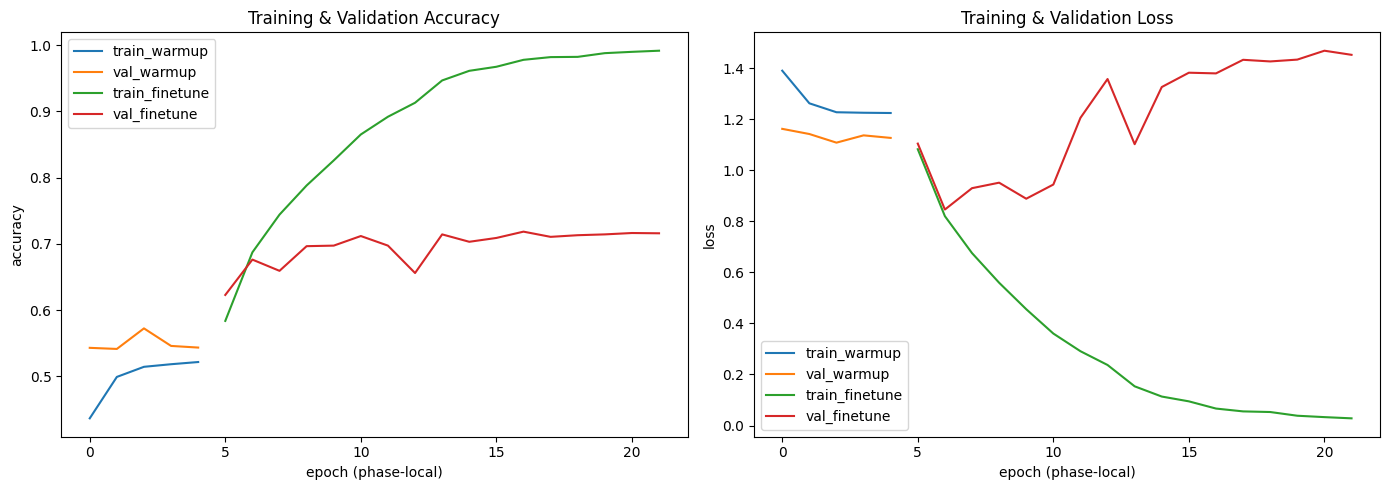

In [11]:
hist = pd.read_csv(reports_dir / "history.csv")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Accuracy curve ---
ax = axes[0]
for ph in ["warmup", "finetune"]:
    sub = hist[hist["phase"] == ph]
    if not sub.empty:
        if "accuracy" in sub:
            ax.plot(sub.index, sub["accuracy"], label=f"train_{ph}")
        if "val_accuracy" in sub:
            ax.plot(sub.index, sub["val_accuracy"], label=f"val_{ph}")
ax.set_xlabel("epoch (phase-local)")
ax.set_ylabel("accuracy")
ax.legend()
ax.set_title("Training & Validation Accuracy")

# --- Loss curve ---
ax = axes[1]
for ph in ["warmup", "finetune"]:
    sub = hist[hist["phase"] == ph]
    if not sub.empty:
        if "loss" in sub:
            ax.plot(sub.index, sub["loss"], label=f"train_{ph}")
        if "val_loss" in sub:
            ax.plot(sub.index, sub["val_loss"], label=f"val_{ph}")
ax.set_xlabel("epoch (phase-local)")
ax.set_ylabel("loss")
ax.legend()
ax.set_title("Training & Validation Loss")

plt.tight_layout()
plt.savefig(reports_dir / "combined_curves.png", dpi=160)
plt.show()


# quick sanity: evaluate on validation set

In [32]:
val_probs = model.predict(val_ds, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)
val_true  = [LABEL2ID[l] for l in val_df["label"].tolist()]
print(pd.DataFrame(
    classification_report(val_true, val_pred, target_names=CLASSES, output_dict=True)
).transpose().round(4))


              precision  recall  f1-score    support
angry            0.6475  0.5940    0.6196   399.0000
happy            0.8077  0.8435    0.8252   722.0000
sad              0.6352  0.6418    0.6385   483.0000
surprise         0.8729  0.8233    0.8474   317.0000
neutral          0.6262  0.6439    0.6349   497.0000
accuracy         0.7184  0.7184    0.7184     0.7184
macro avg        0.7179  0.7093    0.7131  2418.0000
weighted avg     0.7181  0.7184    0.7178  2418.0000


# Export TFLite INT8 + latency check

In [33]:
export_dir = Path("./exports"); export_dir.mkdir(parents=True, exist_ok=True)
tfl_path = str(export_dir / "mobilenetv2_int8.tflite")

SAMPLE_N = min(200, len(train_df))
sample_files = train_df["path"].sample(SAMPLE_N, random_state=SEED).tolist()
def representative_dataset():
    for fp in sample_files:
        img = tf.io.read_file(fp)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img*255.0)
        img = tf.reshape(img, [1, IMG_SIZE, IMG_SIZE, 3])
        yield [img]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()
open(tfl_path, "wb").write(tflite_model)
print("Saved TFLite:", tfl_path)

# Latency (CPU)
interpreter = tf.lite.Interpreter(model_path=tfl_path, num_threads=os.cpu_count() or 1)
interpreter.allocate_tensors()
in_idx  = interpreter.get_input_details()[0]["index"]
out_idx = interpreter.get_output_details()[0]["index"]

# one test image
test_img_path = test_df["path"].iloc[0] if len(test_df) else train_df["path"].iloc[0]
raw = tf.io.read_file(test_img_path)
img = tf.io.decode_jpeg(raw, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img = tf.cast(img, tf.uint8)[None, ...]

for _ in range(5):
    interpreter.set_tensor(in_idx, img.numpy()); interpreter.invoke()

import time
N=100; start=time.time()
for _ in range(N):
    interpreter.set_tensor(in_idx, img.numpy()); interpreter.invoke()
dt = (time.time()-start)/N
print(f"Avg inference: {dt*1000:.1f} ms / frame (CPU, IMG_SIZE={IMG_SIZE})")


Saved artifact at 'C:\Users\heshm\AppData\Local\Temp\tmp48oh4fuo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_313')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2574695248720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574695249488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574695248336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574695249296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574695251216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574695248912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574728560720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574695248144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574728561488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2574695240656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved TFLite: exports\mobilenetv2_int8.tflite


c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Avg inference: 3.5 ms / frame (CPU, IMG_SIZE=224)


# summary

In [34]:
run_summary = {
    "out_dir": str(OUT_DIR),
    "classes": CLASSES,
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "warmup_epochs": WARMUP_EPOCHS,
    "fine_tune_epochs": FINE_EPOCHS,
    "unfrozen_layers": 30,
    "artifacts": {
        "model_summary.txt": "reports/model_summary.txt",
        "model_summary_finetuned.txt": "reports/model_summary_finetuned.txt",
        "model_architecture.png": "reports/model_architecture.png",
        "history.csv": "reports/history.csv",
        "accuracy_curve.png": "reports/accuracy_curve.png",
        "loss_curve.png": "reports/loss_curve.png",
        "tflite_int8": "exports/mobilenetv2_int8.tflite"
    }
}
print(json.dumps(run_summary, indent=2))


{
  "out_dir": "..\\..\\data\\processed\\FC211042_Heshani",
  "classes": [
    "angry",
    "happy",
    "sad",
    "surprise",
    "neutral"
  ],
  "img_size": 224,
  "batch_size": 16,
  "warmup_epochs": 5,
  "fine_tune_epochs": 20,
  "unfrozen_layers": 30,
  "artifacts": {
    "model_summary.txt": "reports/model_summary.txt",
    "model_summary_finetuned.txt": "reports/model_summary_finetuned.txt",
    "model_architecture.png": "reports/model_architecture.png",
    "history.csv": "reports/history.csv",
    "accuracy_curve.png": "reports/accuracy_curve.png",
    "loss_curve.png": "reports/loss_curve.png",
    "tflite_int8": "exports/mobilenetv2_int8.tflite"
  }
}
